In [1]:
# For reproducability
import os
os.environ['PYTHONHASHSEED'] = '29'
import numpy as np
np.random.seed(29)
import random
random.seed(29)
import tensorflow
tensorflow.random.set_seed(29)

In [2]:
#Importing packages
import pandas as pd
import matplotlib.pyplot as plt

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Using TensorFlow backend.


In [3]:
# Load in raw dataset
weather_df_norm = pd.read_csv('dataset/dutch_weather_norm_raw.csv', parse_dates = ['DATE'])

In [4]:
# Knobs
n_future = 1 # How many steps in the future do I want to predict
n_past = 7 # How many past steps do I want to use to predict n_future
feature_columns = ['CLOUDINESS', 'HUMIDITY', 'MAX_TEMP', 'MIN_TEMP', 'MEAN_TEMP', 'PRECIPITATION']

In [5]:
# Define functions
def multivariate_supervised_learning(length, n_future = 1, n_past = 7):
    """
    Input:
    length = length for evaluation
    n_future = future time-steps to be predicted
    n_past = past timesteps to be predicted
    
    Output:
    Train test splits for control variables (X) and target variable (u) as numpy arrays
    """
    if length == 'short':
        length = weather_df_norm[0:732][feature_columns]
    elif length == 'medium':
        length = weather_df_norm[0:7304][feature_columns]
    elif length == 'long':
        length = weather_df_norm[0:21914][feature_columns]
    else:
        print('No proper length accepted')
        return 0
    
    X = []
    y = []
    
    for i in range(n_past, len(length) - n_future + 1):
        X.append(length[i - n_past:i])
        y.append(length[i + n_future - 1: i + n_future]['PRECIPITATION'])
    
    train_len = round(0.5 * len(X))
    val_len = round(0.5 * train_len)
    
    X_train = np.array(X[:train_len])
    X_val = np.array(X[train_len:train_len + val_len])
    X_test = np.array(X[train_len + val_len:])
    
    y_train = np.array(y[:train_len])
    y_val = np.array(y[train_len:train_len + val_len])
    y_test = np.array(y[train_len + val_len:])

    return X_train, X_val, X_test, y_train, y_val, y_test

def plot_lstm_results(history, length, batch_size, neurons):
    """
    Input: 
    history = history object from training neural network
    length = dataset size
    batch_size = batch size the network was trained on
    neurons = amount of neurons in the layers
    
    Output:
    Saves figure comparing training to validation loss
    """
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.savefig(f'graphs/{length}_raw_neurons_{str(neurons)}_batchsize_{str(batch_size)}')
    
def plot_actual_vs_predict_lstm_train_val(yhat_train, yhat_val, y_train, y_val, length):
    """
    Input:
    yhat_train = predicted training set values
    yhat_val = predicted validation set values
    y_train = actual training set values
    y_val = actual validation set values
    length = dataset size
    
    Output:
    Shows figure comparing actuals vs. predicted values for training and validation set
    """
    plt.figure(figsize = (10, 5))
    plt.plot(weather_df_norm['DATE'][n_past : n_past + len(y_train) + len(y_val)], np.concatenate((y_train, y_val), axis = None), label = 'Actuals')
    plt.plot(weather_df_norm['DATE'][n_past : n_past + len(y_train)], yhat_train, label = 'Predicted training set')
    plt.plot(weather_df_norm['DATE'][n_past + len(y_train) : n_past + len(y_train) + len(y_val)], yhat_val, label = 'Predicted validation set')
    plt.legend()
    plt.show()
    
def plot_actual_vs_predict_lstm_test(y_train, y_val, yhat_test, y_test, length):
    """
    Input:
    y_train = actual training set values
    y_val = actual validation set values
    yhat_test = predicted test set values
    y_test = actual test set values
    length = dataset size
    
    Output:
    Shows figure comparing actuals vs. predicted values for test set
    """
    plt.figure(figsize = (10, 5))
    plt.plot(weather_df_norm['DATE'][n_past + len(y_train) + len(y_val) : n_past + len(y_train) + len(y_val) + len(y_test)], yhat_test, label = 'Actual test set')
    plt.plot(weather_df_norm['DATE'][n_past + len(y_train) + len(y_val) : n_past + len(y_train) + len(y_val) + len(y_test)], y_test, label = 'Predicted test set')
    plt.legend()
    plt.show()

## Short time-series

In [6]:
# Create supervised learning problem LSTM short
X_train_short, X_val_short, X_test_short, y_train_short, y_val_short, y_test_short = multivariate_supervised_learning('short', n_future = 1, n_past = 7)

In [7]:
# Build LSTM Model
batch_size = 11
epochs = 30
    
model_short = Sequential()
model_short.add(LSTM(25, activation = 'relu', input_shape = (X_train_short.shape[1], X_train_short.shape[2]), return_sequences = False))
model_short.add(Dense(1, activation = 'linear'))
model_short.compile(optimizer = 'RMSprop', loss = 'mse')

#Initiate early stopping
callback = EarlyStopping(monitor = 'mse', patience = 3)

#Fit model
history_short = model_short.fit(X_train_short, y_train_short, epochs = epochs, batch_size = batch_size, shuffle = False, validation_data = (X_val_short, y_val_short), verbose = 0)

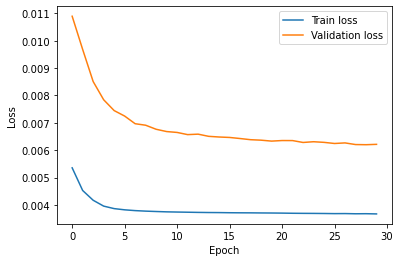

In [8]:
# Plot loss function training & validation
plot_lstm_results(history_short, 'short', batch_size, neurons = 25)

In [9]:
# Print model summary
model_short.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25)                3200      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 3,226
Trainable params: 3,226
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Predictions on training & validation set
yhat_train_short = model_short.predict(X_train_short)
yhat_val_short = model_short.predict(X_val_short)

# Predictions on test set
yhat_test_short = model_short.predict(X_test_short)

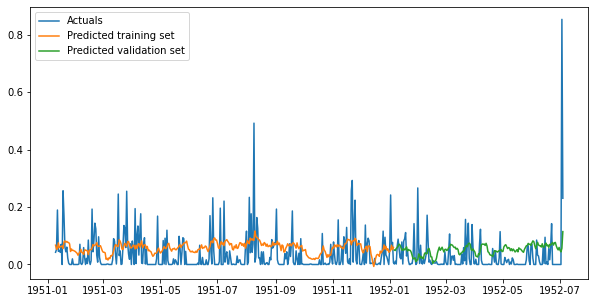

In [11]:
# Plot actual vs predicted for train & validation
plot_actual_vs_predict_lstm_train_val(yhat_train_short, yhat_val_short, y_train_short, y_val_short, 'short')

In [12]:
# Scores for training
rmse_short_lstm_train = mean_squared_error(y_train_short, yhat_train_short, squared = False)
mae_short_lstm_train = mean_absolute_error(y_train_short, yhat_train_short)
r2_short_lstm_train = r2_score(y_train_short, yhat_train_short)

# Scores for validation
rmse_short_lstm_val = mean_squared_error(y_val_short, yhat_val_short, squared = False)
mae_short_lstm_val = mean_absolute_error(y_val_short, yhat_val_short)
r2_short_lstm_val = r2_score(y_val_short, yhat_val_short)

In [13]:
# Display training and validation scores
print('              MAE  |  RMSE |  R2')
print('----------------------------------')
print(f'      Train: {round(mae_short_lstm_train, 3)} | {round(rmse_short_lstm_train, 3)} | {round(r2_short_lstm_train, 3)}')
print(f' Validation: {round(mae_short_lstm_val, 3)} | {round(rmse_short_lstm_val, 3)} | {round(r2_short_lstm_val, 3)}')

              MAE  |  RMSE |  R2
----------------------------------
      Train: 0.051 | 0.063 | -0.049
 Validation: 0.048 | 0.079 | -0.1


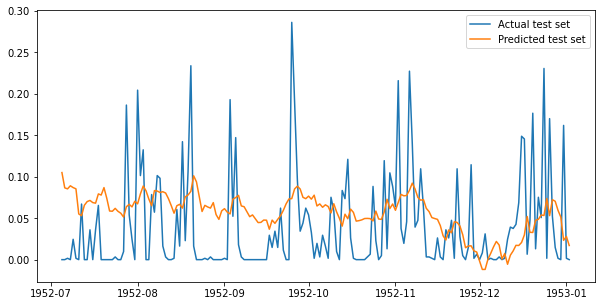

In [14]:
# Plot actual vs predicted for testing
plot_actual_vs_predict_lstm_test(y_train_short, y_val_short, y_test_short, yhat_test_short, 'short')

In [15]:
# Scores for testing
rmse_short_lstm_test = mean_squared_error(y_test_short, yhat_test_short, squared = False)
mae_short_lstm_test = mean_absolute_error(y_test_short, yhat_test_short)
r2_short_lstm_test = r2_score(y_test_short, yhat_test_short)

In [16]:
# Display test scores
print('              MAE  |  RMSE |  R2')
print('----------------------------------')
print(f'      Test: {round(mae_short_lstm_test, 3)}  | {round(rmse_short_lstm_test, 3)} | {round(r2_short_lstm_test, 3)}')

              MAE  |  RMSE |  R2
----------------------------------
      Test: 0.051  | 0.062 | -0.13


## Long time-series

In [17]:
## Create supervised learning problem LSTM long
X_train_long, X_val_long, X_test_long, y_train_long, y_val_long, y_test_long = multivariate_supervised_learning('long', n_future = 1, n_past = 7)

In [18]:
# Build LSTM Model
batch_size = 86
epochs = 50
    
model_long = Sequential()
model_long.add(LSTM(25, activation = 'relu', input_shape = (X_train_long.shape[1], X_train_long.shape[2]), return_sequences = False))
model_long.add(Dense(1, activation = 'linear'))
model_long.compile(optimizer = 'RMSprop', loss = 'mse')

#Initiate early stopping
callback = EarlyStopping(monitor = 'mse', patience = 3)

#Fit model
history_long = model_long.fit(X_train_long, y_train_long, epochs = epochs, batch_size = batch_size, shuffle = False, validation_data = (X_val_long, y_val_long), verbose = 0)

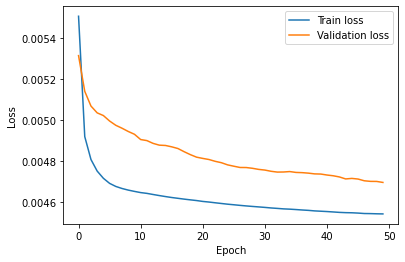

In [19]:
# Plot loss function training & validation
plot_lstm_results(history_long, 'long', batch_size, neurons = 25)

In [20]:
# Print model summary
model_long.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 25)                3200      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 3,226
Trainable params: 3,226
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Predictions on training & validation set
yhat_train_long = model_long.predict(X_train_long)
yhat_val_long = model_long.predict(X_val_long)

# Predictions on test set
yhat_test_long = model_long.predict(X_test_long)

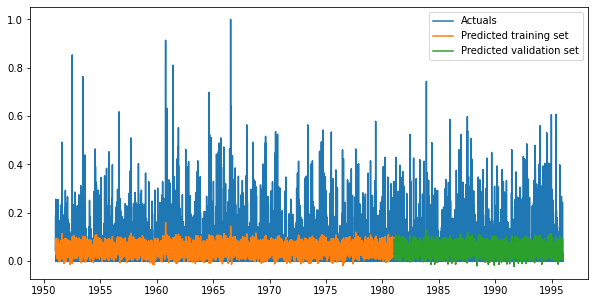

In [22]:
# Plot actual vs predicted for train & validation
plot_actual_vs_predict_lstm_train_val(yhat_train_long, yhat_val_long, y_train_long, y_val_long, 'long')

In [23]:
# Scores for training
rmse_long_lstm_train = mean_squared_error(y_train_long, yhat_train_long, squared = False)
mae_long_lstm_train = mean_absolute_error(y_train_long, yhat_train_long)
r2_long_lstm_train = r2_score(y_train_long, yhat_train_long)

# Scores for validation
rmse_long_lstm_val = mean_squared_error(y_val_long, yhat_val_long, squared = False)
mae_long_lstm_val = mean_absolute_error(y_val_long, yhat_val_long)
r2_long_lstm_val = r2_score(y_val_long, yhat_val_long)

In [24]:
# Display training & validation scores
print('              MAE  |  RMSE |  R2')
print('----------------------------------')
print(f'      Train: {round(mae_long_lstm_train, 3)} | {round(rmse_long_lstm_train, 3)} | {round(r2_long_lstm_train, 3)}')
print(f' Validation: {round(mae_long_lstm_val, 3)} | {round(rmse_long_lstm_val, 3)} | {round(r2_long_lstm_val, 3)}')

              MAE  |  RMSE |  R2
----------------------------------
      Train: 0.045 | 0.068 | 0.074
 Validation: 0.046 | 0.069 | 0.091


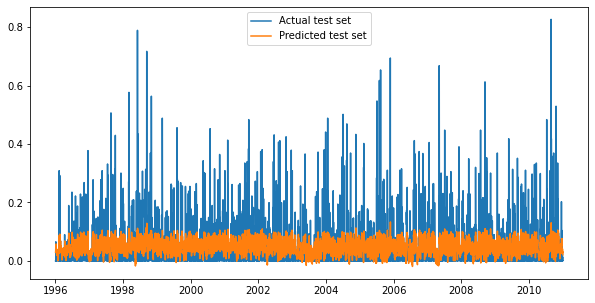

In [25]:
# Plot actual vs predicted for testing
plot_actual_vs_predict_lstm_test(y_train_long, y_val_long, y_test_long, yhat_test_long, 'long')

In [26]:
# Scores for testing
rmse_long_lstm_test = mean_squared_error(y_test_long, yhat_test_long, squared = False)
mae_long_lstm_test = mean_absolute_error(y_test_long, yhat_test_long)
r2_long_lstm_test = r2_score(y_test_long, yhat_test_long)

In [27]:
# Display test scores
print('              MAE  |  RMSE |  R2')
print('----------------------------------')
print(f'      Test: {round(mae_long_lstm_test, 3)}  | {round(rmse_long_lstm_test, 3)} | {round(r2_long_lstm_test, 3)}')

              MAE  |  RMSE |  R2
----------------------------------
      Test: 0.048  | 0.073 | 0.076
